# Création Dags et définition des dépendances entre les DAG dans Airflow

Lorsque deux DAG ont des relations de dépendance, il convient d'envisager de les combiner en un seul DAG, qui est généralement plus simple à comprendre. Airflow offre également une meilleure représentation visuelle de dépendances pour les tâches sur le même DAG. Cependant, il n'est parfois pas pratique de mettre tous les éléments connexes tâches sur le même DAG.

## 1. Création des deux dags Parents 'dag en amont'

Pour la création des deux dags parents , il faut commencer par la création des deux fichirs 'parent_dag_1.py' et 'parent_dag_2.py' dans le dossier 'dags' .

In [ ]:
└───dags|── parent_dag_1.py                  
        └── parent_dag_2.py

### 1 - parent_dag_1.py

In [ ]:
from airflow import models
from airflow.operators.dummy_operator import DummyOperator
from airflow.operators import python_operator
from airflow.utils.dates import days_ago


with models.DAG(
    'dag_1',
    schedule_interval='*/1 * * * *', # Chaque minute
    start_date=days_ago(0),
    catchup=False) as dag:
  def greeting():
    """Just check that the DAG is started in the log."""
    import logging
    logging.info('Bonjour le monde depuis le DAG 1')

  hello_python = python_operator.PythonOperator(
    task_id='bonjour',
    python_callable=greeting)

  goodbye_dummy = DummyOperator(task_id='au revoir')

  hello_python >> goodbye_dummy

Ce code crée un DAG simple dans Airflow appelé "dag_1", qui contient deux tâches :

La première tâche s'appelle "hello_python" et utilise l'opérateur Python pour exécuter la fonction "greeting()". Cette fonction écrit simplement "Bonjour le monde depuis le DAG 1" dans les logs.
La deuxième tâche s'appelle "goodbye_dummy" et utilise l'opérateur DummyOperator pour simuler une tâche de fin. La flèche ">>" entre ces deux tâches définit une dépendance, de sorte que "goodbye_dummy" ne peut être exécuté que lorsque "hello_python" est terminé avec succès.
La ligne "with models.DAG(...)" crée un objet DAG avec les paramètres suivants :

"dag_id": le nom du DAG (dans ce cas "dag_1").
"schedule_interval": la fréquence à laquelle le DAG sera exécuté (dans ce cas toutes les minutes).
"start_date": la date de début du DAG (dans ce cas, il commence immédiatement).
"catchup": un booléen qui indique si Airflow doit rattraper les exécutions manquées depuis la date de début (dans ce cas, c'est désactivé).
En résumé, ce DAG exécutera la fonction "greeting()" toutes les minutes, écrira un message de log et terminera la tâche avec un opérateur "Dummy".

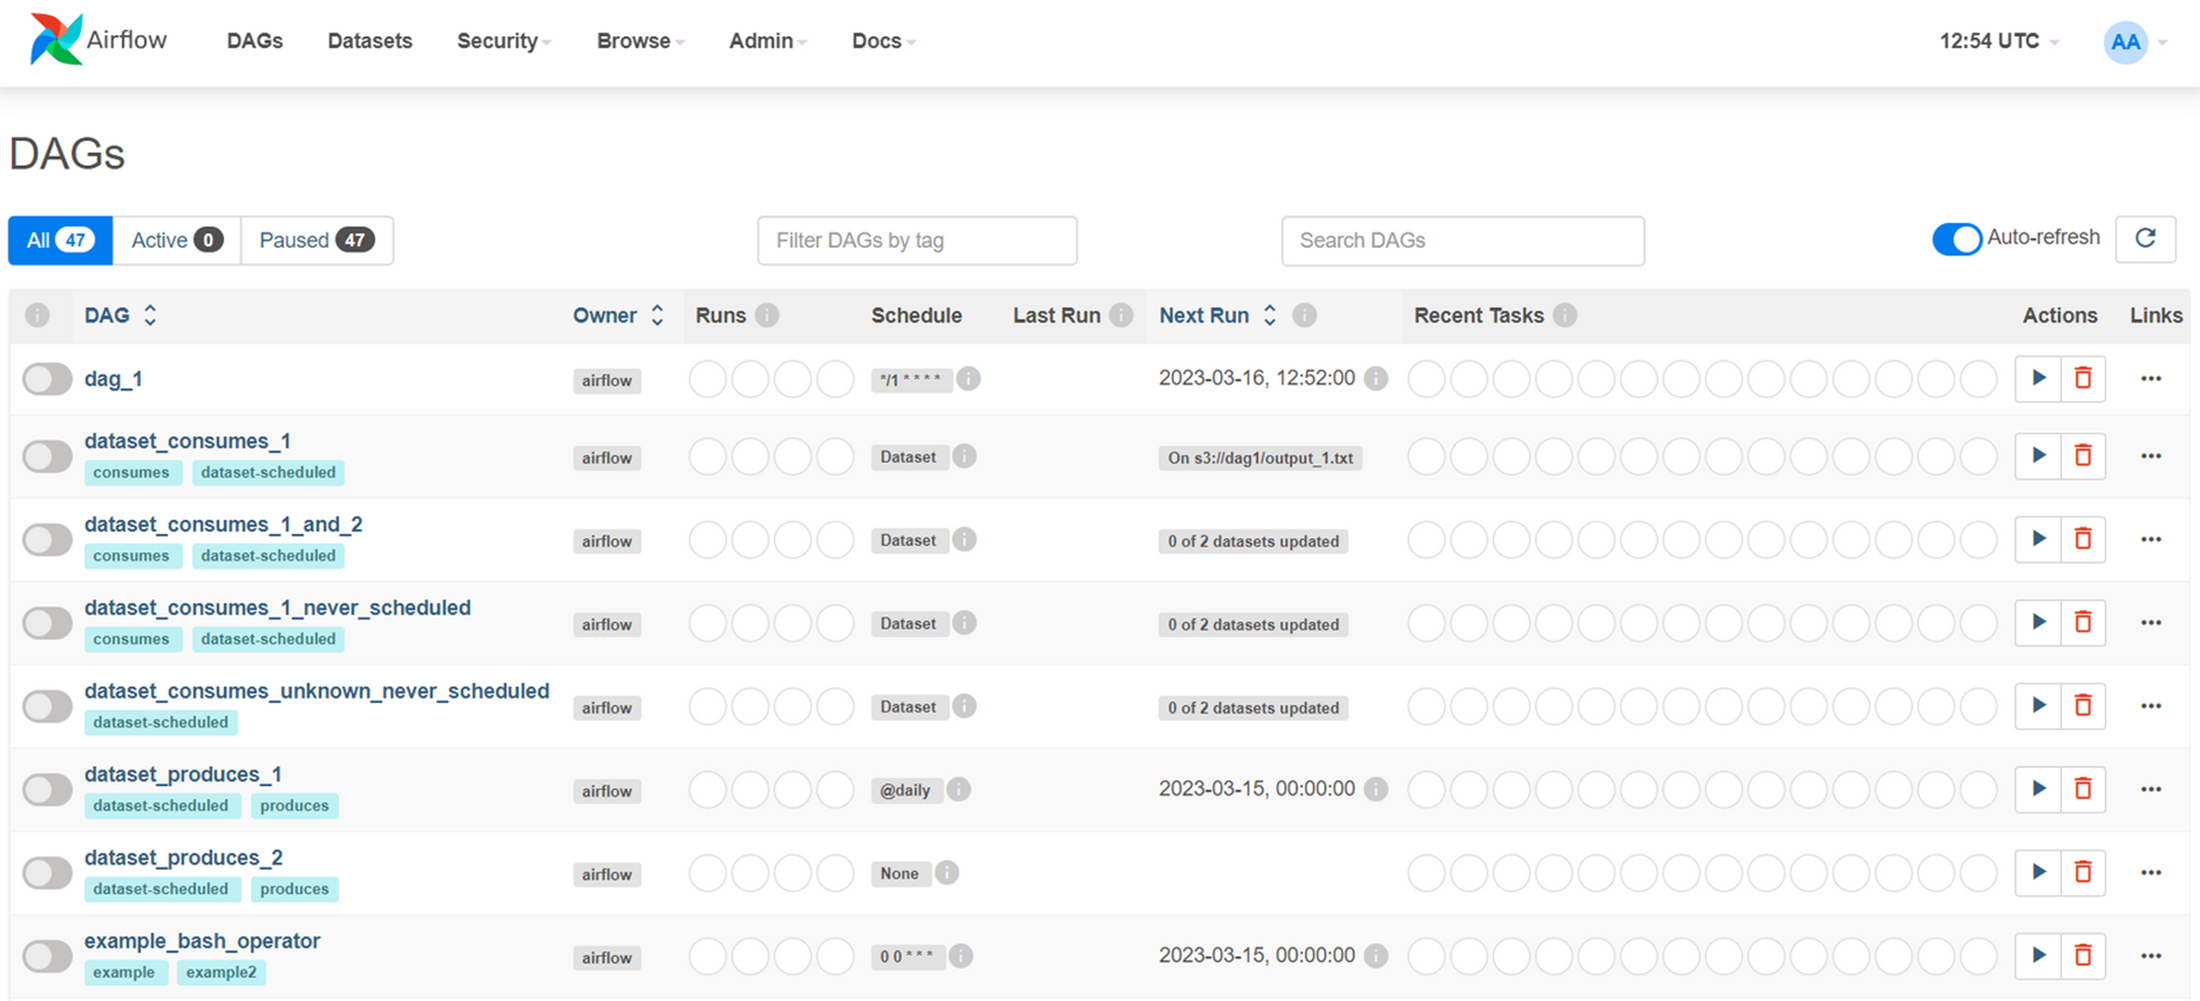

Dans L'interface Utilisateur, Plus Précisément Dans L'interface Graphique Du Dag Nommé Dag_1, Toutes Les Tâches Peuvent Être Repérées.

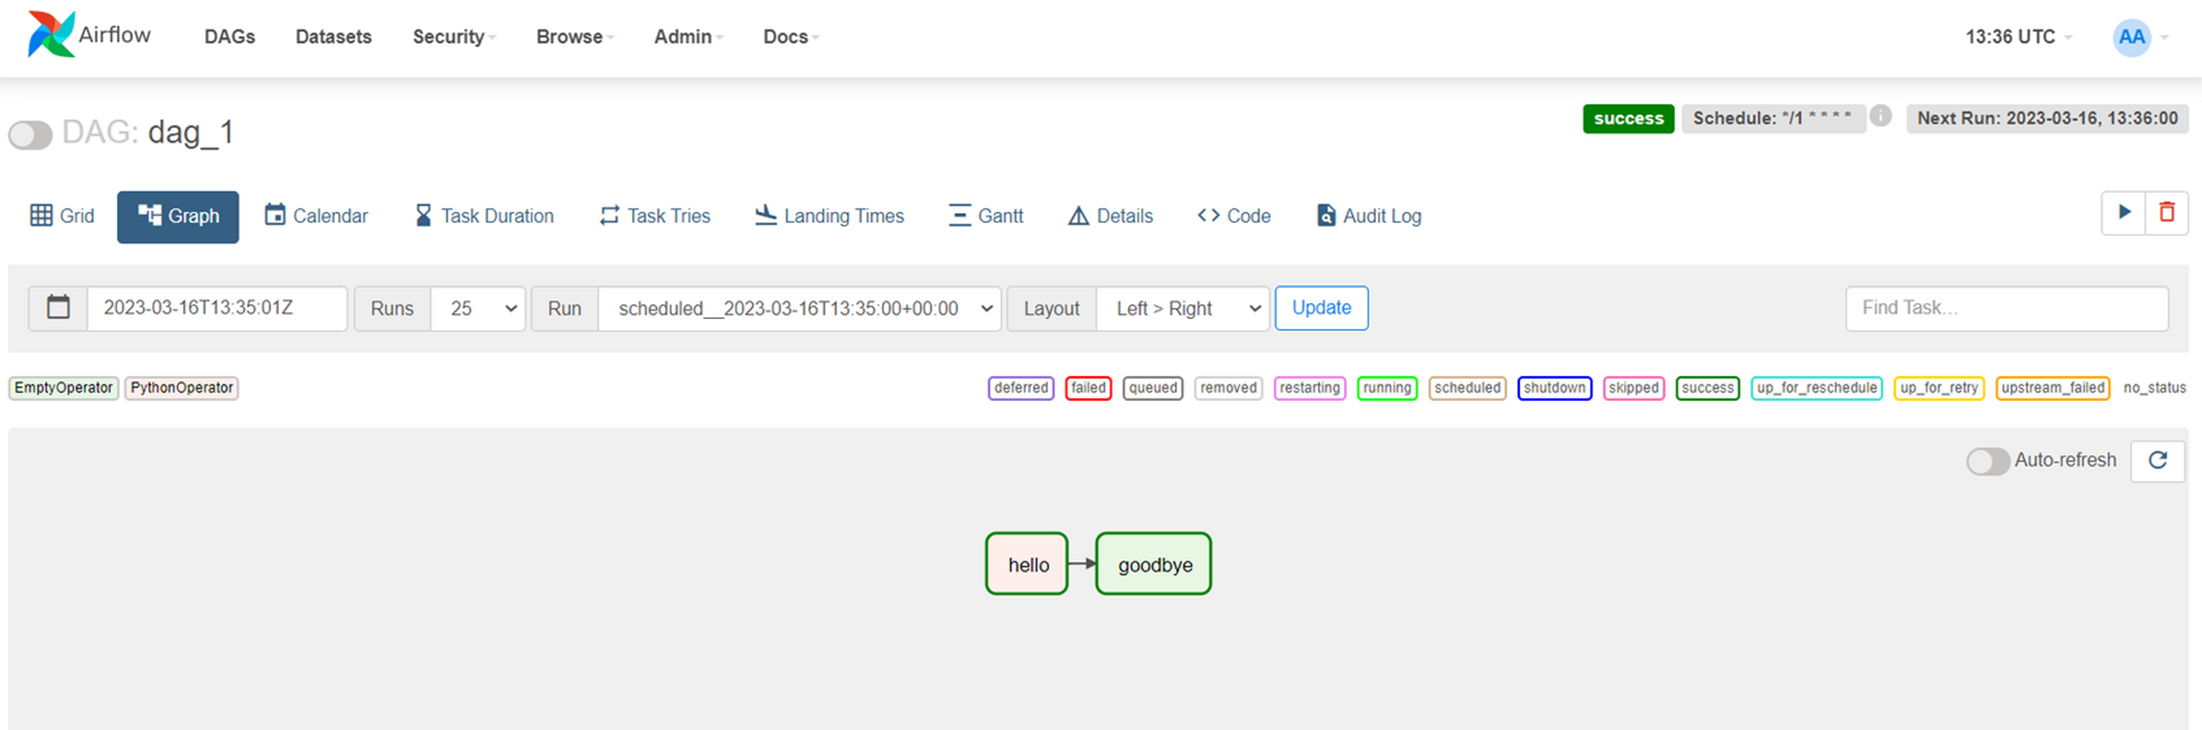

### 2 - parent_dag_2.py

In [ ]:
from airflow import models
from airflow.operators.dummy_operator import DummyOperator
from airflow.operators import python_operator
from airflow.utils.dates import days_ago


with models.DAG(
    'dag_2',
    schedule_interval='*/1 * * * *', # Chaque minute
    start_date=days_ago(0),
    catchup=False) as dag:
  def greeting():
    """Just check that the DAG is started in the log."""
    import logging
    logging.info('Bonjour le monde depuis le DAG 2')

  hello_python = python_operator.PythonOperator(
    task_id='bonjour',
    python_callable=greeting)

  goodbye_dummy = DummyOperator(task_id='au revoir')

  hello_python >> goodbye_dummy

Ce code crée un DAG nommé "dag_2" dans Airflow qui est identique au DAG précédent ("dag_1") que nous avons vu. Il contient deux tâches :

La première tâche s'appelle "hello_python" et utilise l'opérateur Python pour exécuter la fonction "greeting()". Cette fonction écrit simplement "Bonjour le monde depuis le DAG 2" dans les logs.
La deuxième tâche s'appelle "goodbye_dummy" et utilise l'opérateur DummyOperator pour simuler une tâche de fin. La flèche ">>" entre ces deux tâches définit une dépendance, de sorte que "goodbye_dummy" ne peut être exécuté que lorsque "hello_python" est terminé avec succès.
La ligne "with models.DAG(...)" crée un objet DAG avec les paramètres suivants :

"dag_id": le nom du DAG (dans ce cas "dag_2").
"schedule_interval": la fréquence à laquelle le DAG sera exécuté (dans ce cas toutes les minutes).
"start_date": la date de début du DAG (dans ce cas, il commence immédiatement).
"catchup": un booléen qui indique si Airflow doit rattraper les exécutions manquées depuis la date de début (dans ce cas, c'est désactivé).
En résumé, ce DAG exécutera la fonction "greeting()" toutes les minutes, écrira un message de log et terminera la tâche avec un opérateur "Dummy". La seule différence entre ce DAG et le précédent est le nom.



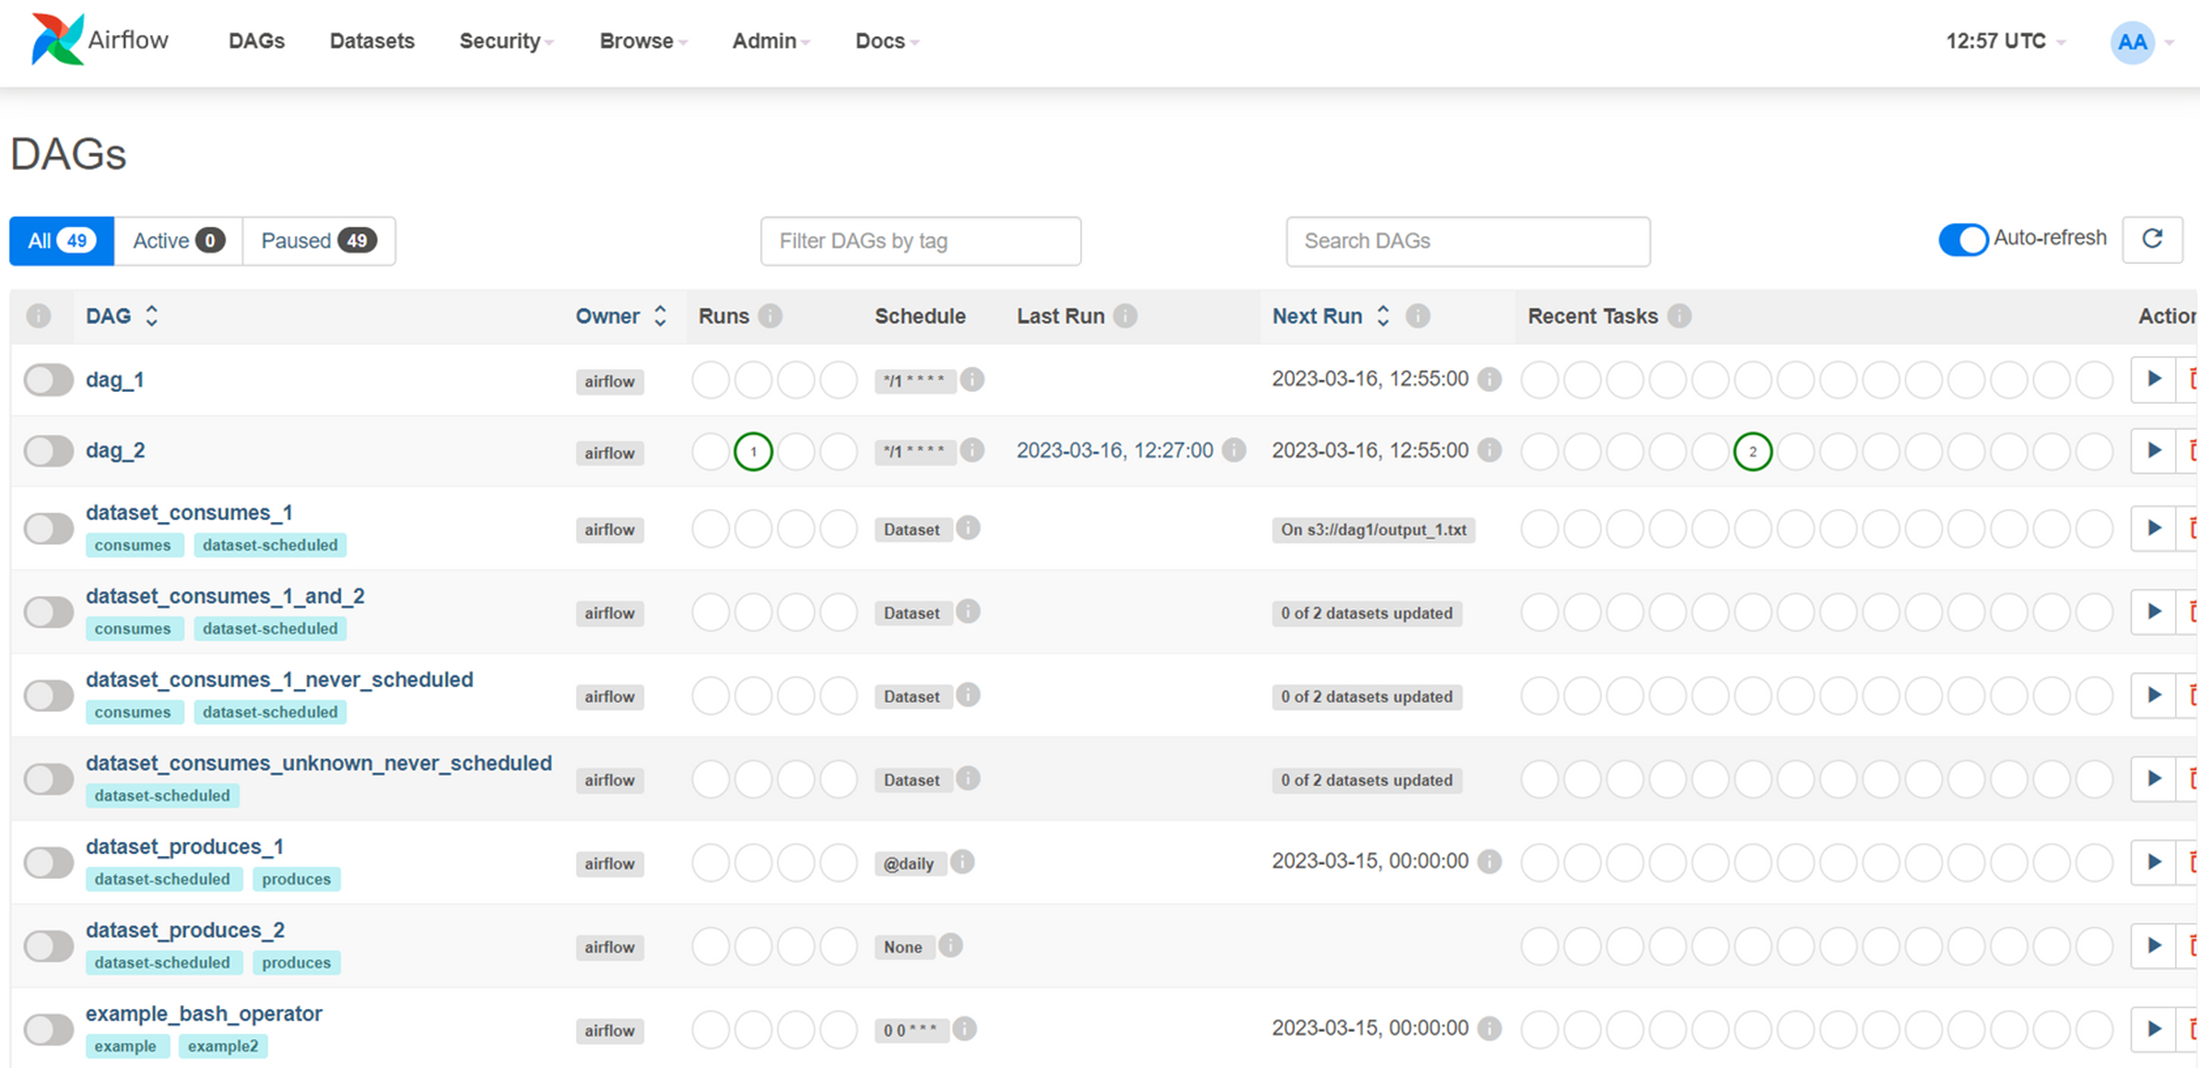

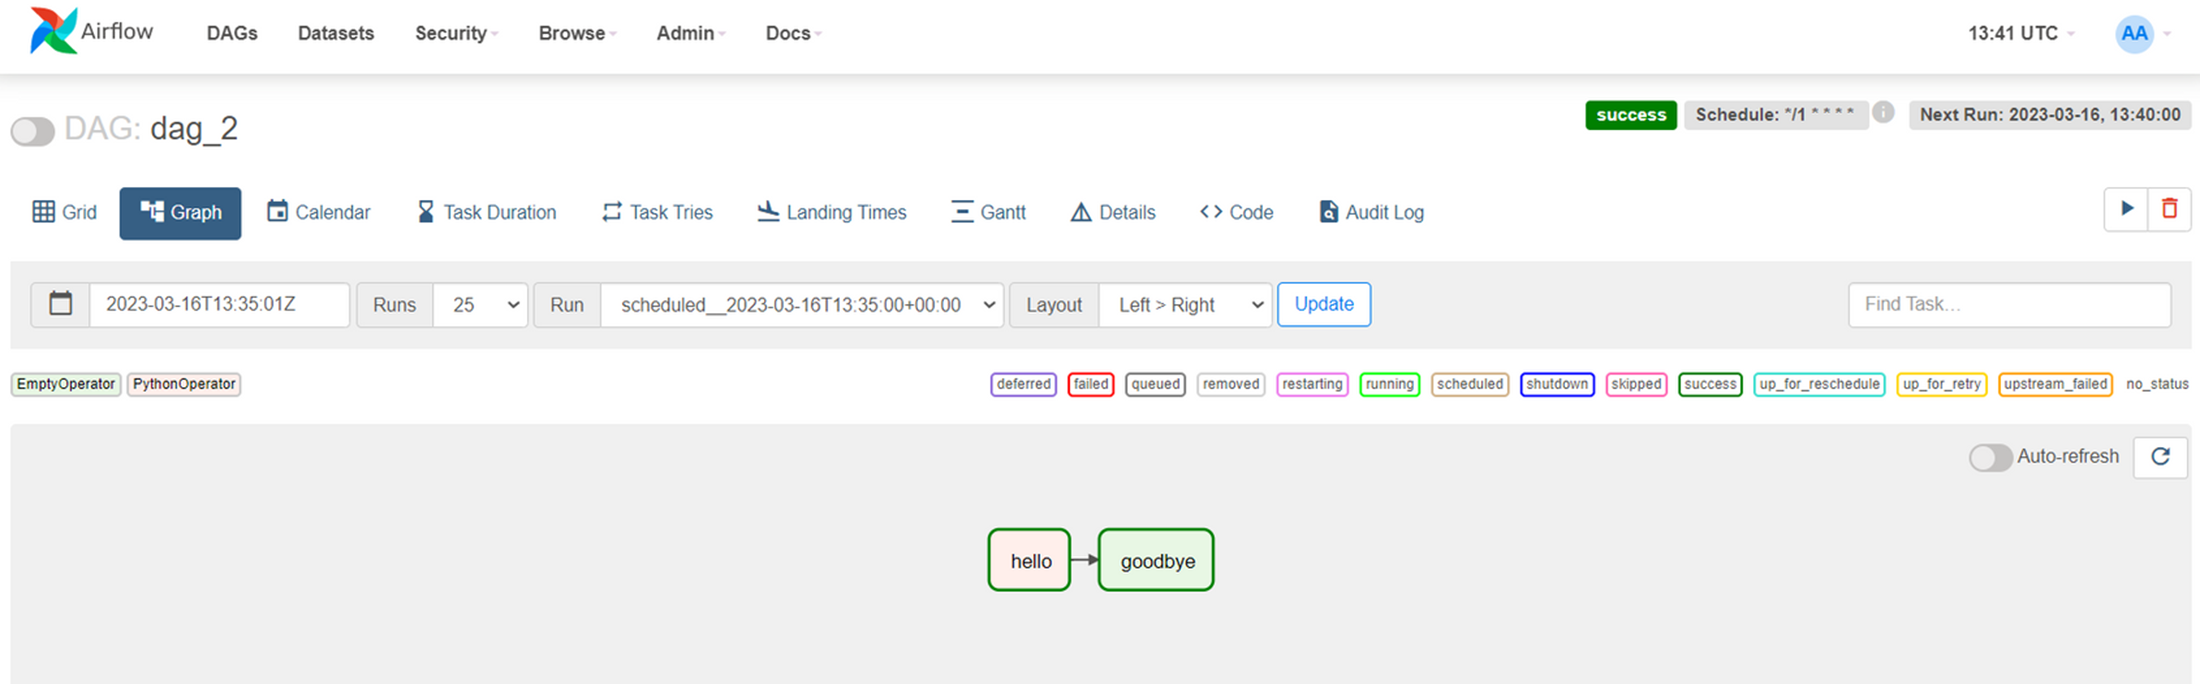

## 2 . Création du dag enfant 'dag en aval'

### child_master_dag.py

In [ ]:
"""Déclenchez les DAGs #1 et #2 et faites quelque chose s'ils réussissent."""

from airflow import DAG
from airflow.sensors.external_task import ExternalTaskSensor
from airflow.operators.dummy_operator import DummyOperator
from airflow.utils.dates import days_ago


with DAG(
    'Dag_master',
    schedule_interval='*/1 * * * *', # Chaque minute
    start_date=days_ago(0),
    catchup=False) as dag:
  def greeting():
    """Vérifiez simplement que le DAG a démarré dans le journal."""
    import logging
    logging.info('Hello World from DAG MASTER')

  externalsensor1 = ExternalTaskSensor(
    task_id='dag_1_completed_status',
    external_dag_id='dag_1',
    external_task_id=None, #Attendez que tout le DAG soit terminé
    check_existence=True,
    timeout=120)

  externalsensor2 = ExternalTaskSensor(
    task_id='dag_2_completed_status',
    external_dag_id='dag_2',
    external_task_id=None, # Attendez que tout le DAG soit terminé
    check_existence=True,
    timeout=120)

  goodbye_dummy = DummyOperator(task_id='goodbye_master')

  [externalsensor1, externalsensor2] >> goodbye_dummy

Le DAG principal est créé en utilisant la méthode DAG() de la bibliothèque Airflow. Le DAG est nommé "Dag_master" et est configuré pour s'exécuter toutes les minutes en utilisant le paramètre schedule_interval.

La date de début est définie comme étant la date d'aujourd'hui en utilisant la fonction days_ago(). Une fonction appelée greeting() est définie pour vérifier que le DAG a démarré en écrivant un message de journalisation ("Hello World from DAG MASTER").

Deux capteurs de tâches externes sont créés pour surveiller les deux DAGs #1 et #2 en attente de leur achèvement. Les capteurs sont configurés avec les paramètres suivants :

task_id: l'identifiant de la tâche
external_dag_id: l'identifiant du DAG externe à surveiller
external_task_id: l'identifiant de la tâche externe à surveiller. Dans ce cas, nous ne surveillons pas une tâche spécifique, mais tout le DAG. Par conséquent, nous avons défini cette valeur sur None.
check_existence: une valeur booléenne pour indiquer si le capteur doit vérifier l'existence de la tâche ou attendre qu'elle soit terminée.
timeout: le temps maximum en secondes pendant lequel le capteur doit attendre avant de déclencher une exception.
Finalement, une tâche "goodbye_master" est créée en utilisant l'opérateur fictif DummyOperator. Cette tâche sera exécutée si les deux capteurs de tâches externes réussissent. Les deux capteurs sont connectés à la tâche "goodbye_master" en utilisant l'opérateur de décalage de bits (>>) pour indiquer que la tâche "goodbye_master" ne doit pas être exécutée tant que les deux capteurs ne se sont pas déclenchés.

En résumé, ce DAG crée deux capteurs de tâches externes pour surveiller deux autres DAGs et attend leur achèvement avant d'exécuter une tâche fictive. Ce code peut être modifié pour effectuer une tâche réelle une fois que les deux DAGs sont terminés avec succès.

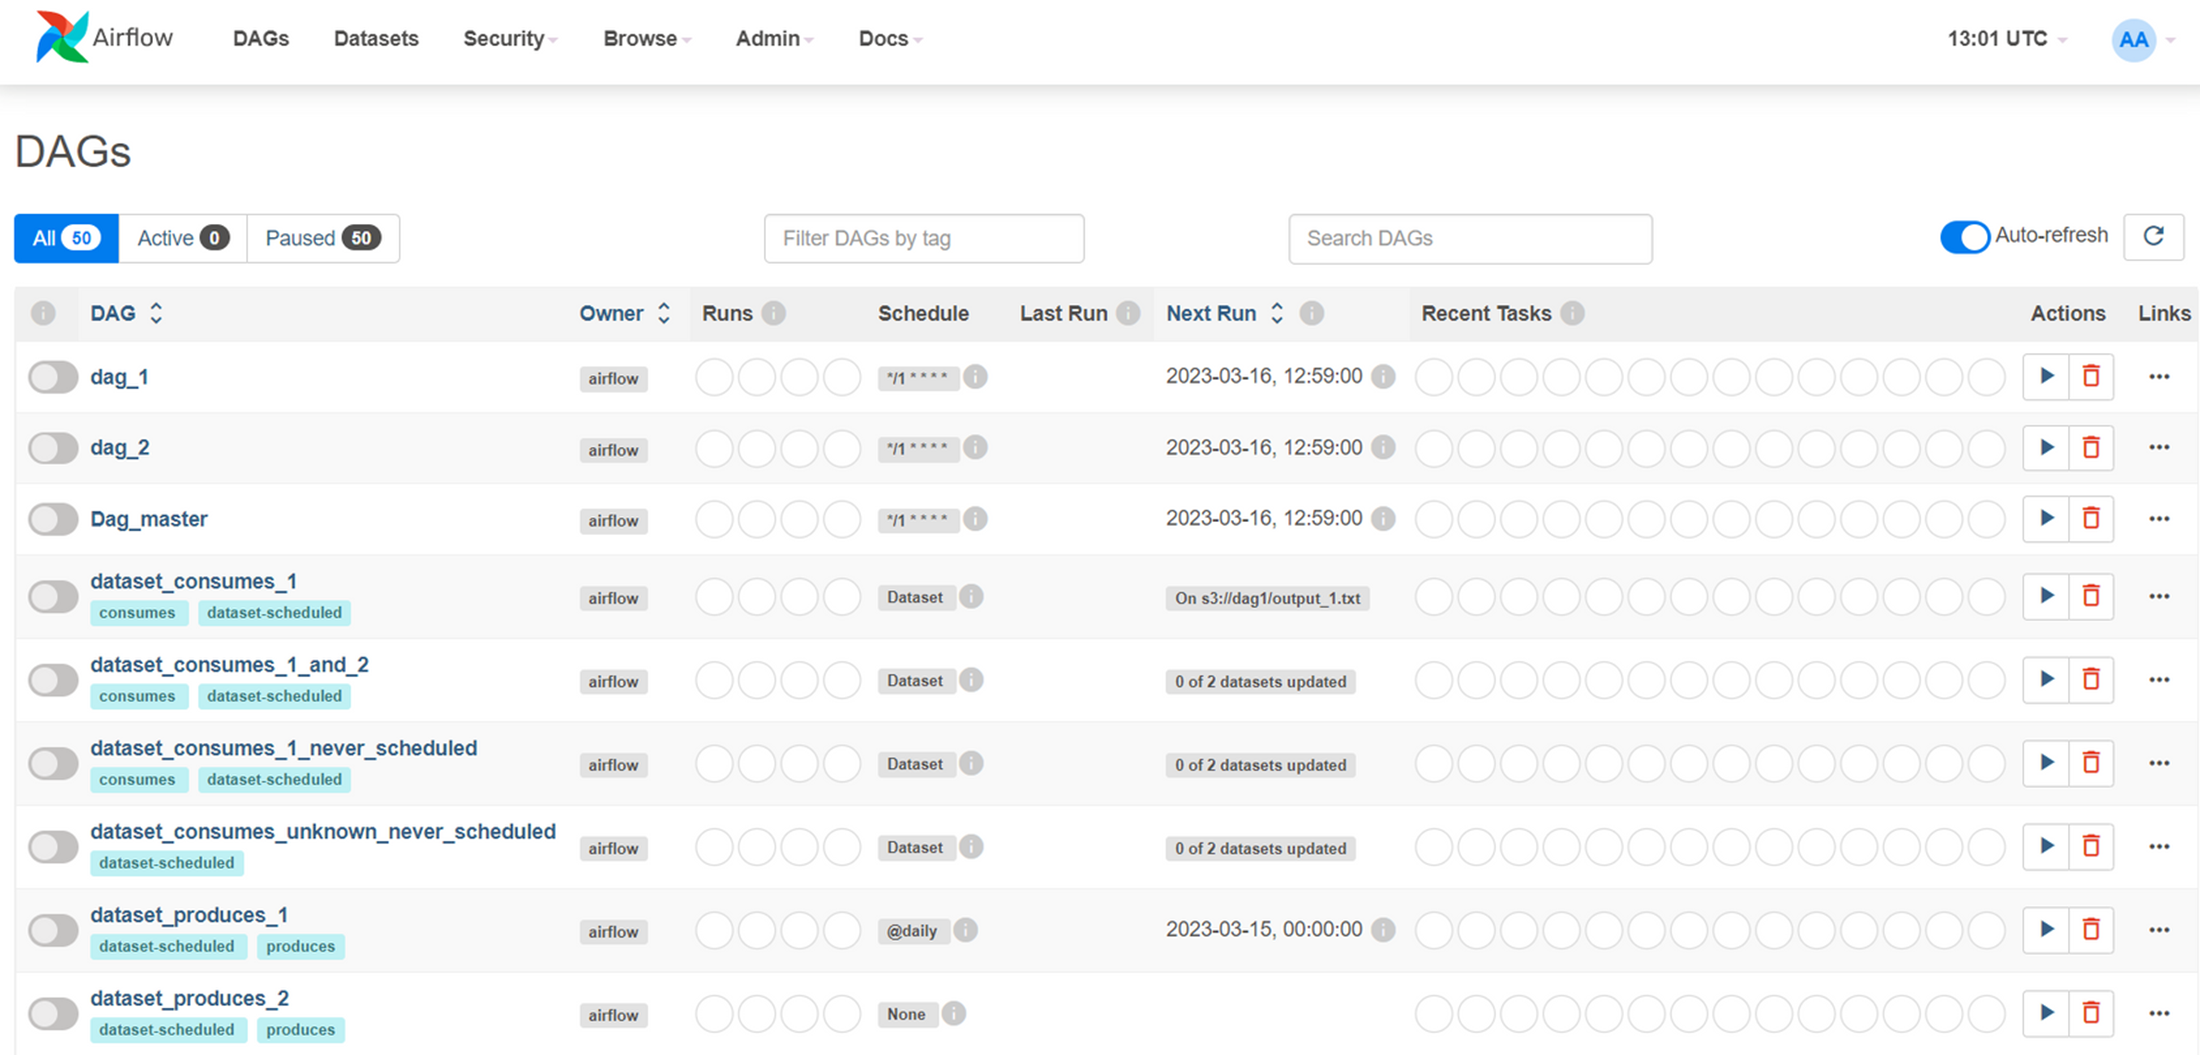

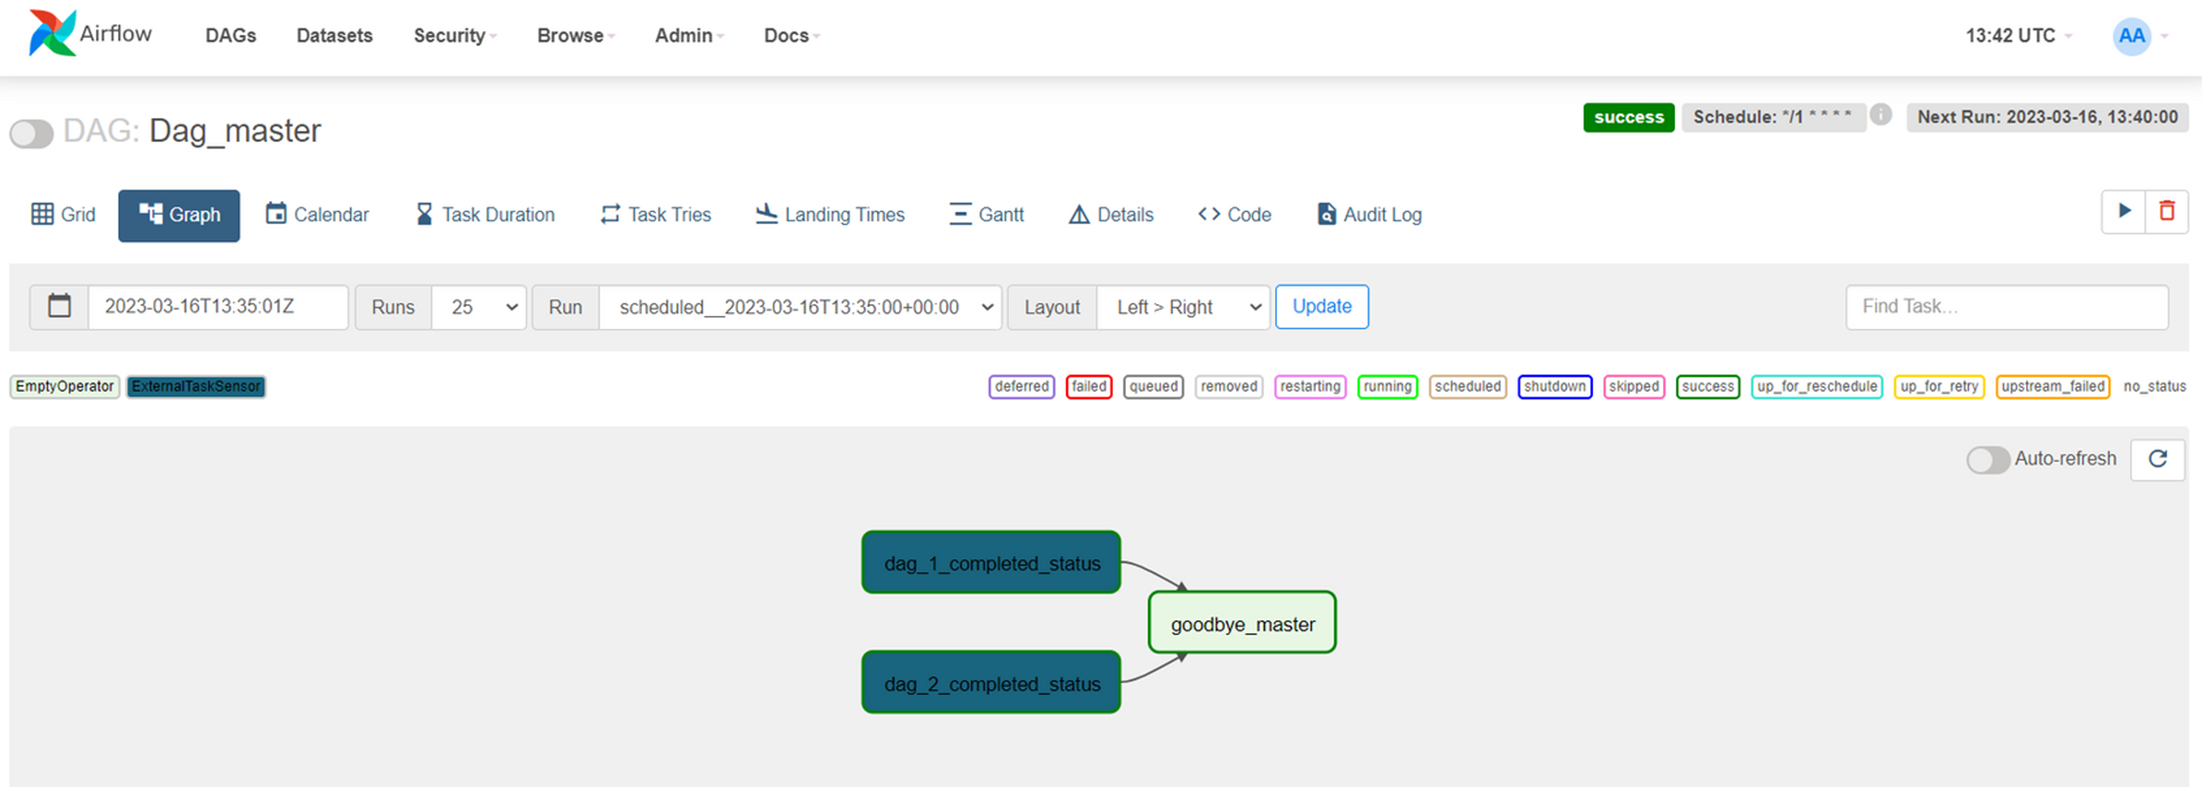

## 3 . DAG QUI S'EXÉCUTENT DEUX TÂCHES SÉQUENTIELLEMENT.

In [ ]:
from airflow.models import DAG
from airflow.utils.dates import days_ago
from airflow.operators.python_operator import PythonOperator
args = {
 
  'owner': 'pipis',
  'start_date': days_ago(1)
}
 
dag = DAG(dag_id = 'my_sample_dag', default_args=args, schedule_interval=None)
 
 
def run_this_func():
  print('I am coming first')
 
def run_also_this_func():
  print('I am coming last')
 
 
with dag:
  run_this_task = PythonOperator(
    task_id='run_this_first',
    python_callable = run_this_func
  )
 
  run_this_task_too = PythonOperator(
    task_id='run_this_last',
    python_callable = run_also_this_func
  )
 
  run_this_task >> run_this_task_too
![image](https://user-images.githubusercontent.com/123757632/227205045-e054e7cf-a76f-410e-b228-da0966c268ad.png)


args = { 'owner': 'pipis', 'start_date': days_ago(1) }: définit un dictionnaire d'arguments qui sera passé au DAG pour définir des paramètres par défaut. Dans ce cas, le propriétaire du DAG est défini comme "pipis" et la date de début est définie comme étant il y a 1 jour.

dag = DAG(dag_id = 'my_sample_dag', default_args=args, schedule_interval=None): définit un objet DAG avec un identifiant de DAG 'my_sample_dag', les paramètres par défaut définis dans args, et un intervalle de planification nul, ce qui signifie qu'il n'y a pas de planification automatique pour les tâches.

def run_this_func(): print('I am coming first'): définit une fonction qui affiche "I am coming first".

def run_also_this_func(): print('I am coming last'): définit une fonction qui affiche "I am coming last".

with dag: crée un bloc de code qui contiendra les tâches de DAG.

run_this_task = PythonOperator(task_id='run_this_first', python_callable = run_this_func): crée une tâche PythonOperator appelée 'run_this_first' qui exécute la fonction run_this_func définie précédemment.

run_this_task_too = PythonOperator(task_id='run_this_last', python_callable = run_also_this_func): crée une autre tâche PythonOperator appelée 'run_this_last' qui exécute la fonction run_also_this_func définie précédemment.

run_this_task >> run_this_task_too: définit la dépendance entre les deux tâches en spécifiant que 'run_this_task_too' doit être exécuté après 'run_this_task' en utilisant l'opérateur >>.

En résumé, ce code définit un DAG avec deux tâches qui exécutent chacune une fonction Python simple qui affiche un message. Les deux tâches sont configurées pour s'exécuter séquentiellement, la deuxième tâche ne démarrant qu'une fois que la première tâche est terminée.

## ACTIVATION DES DAGS


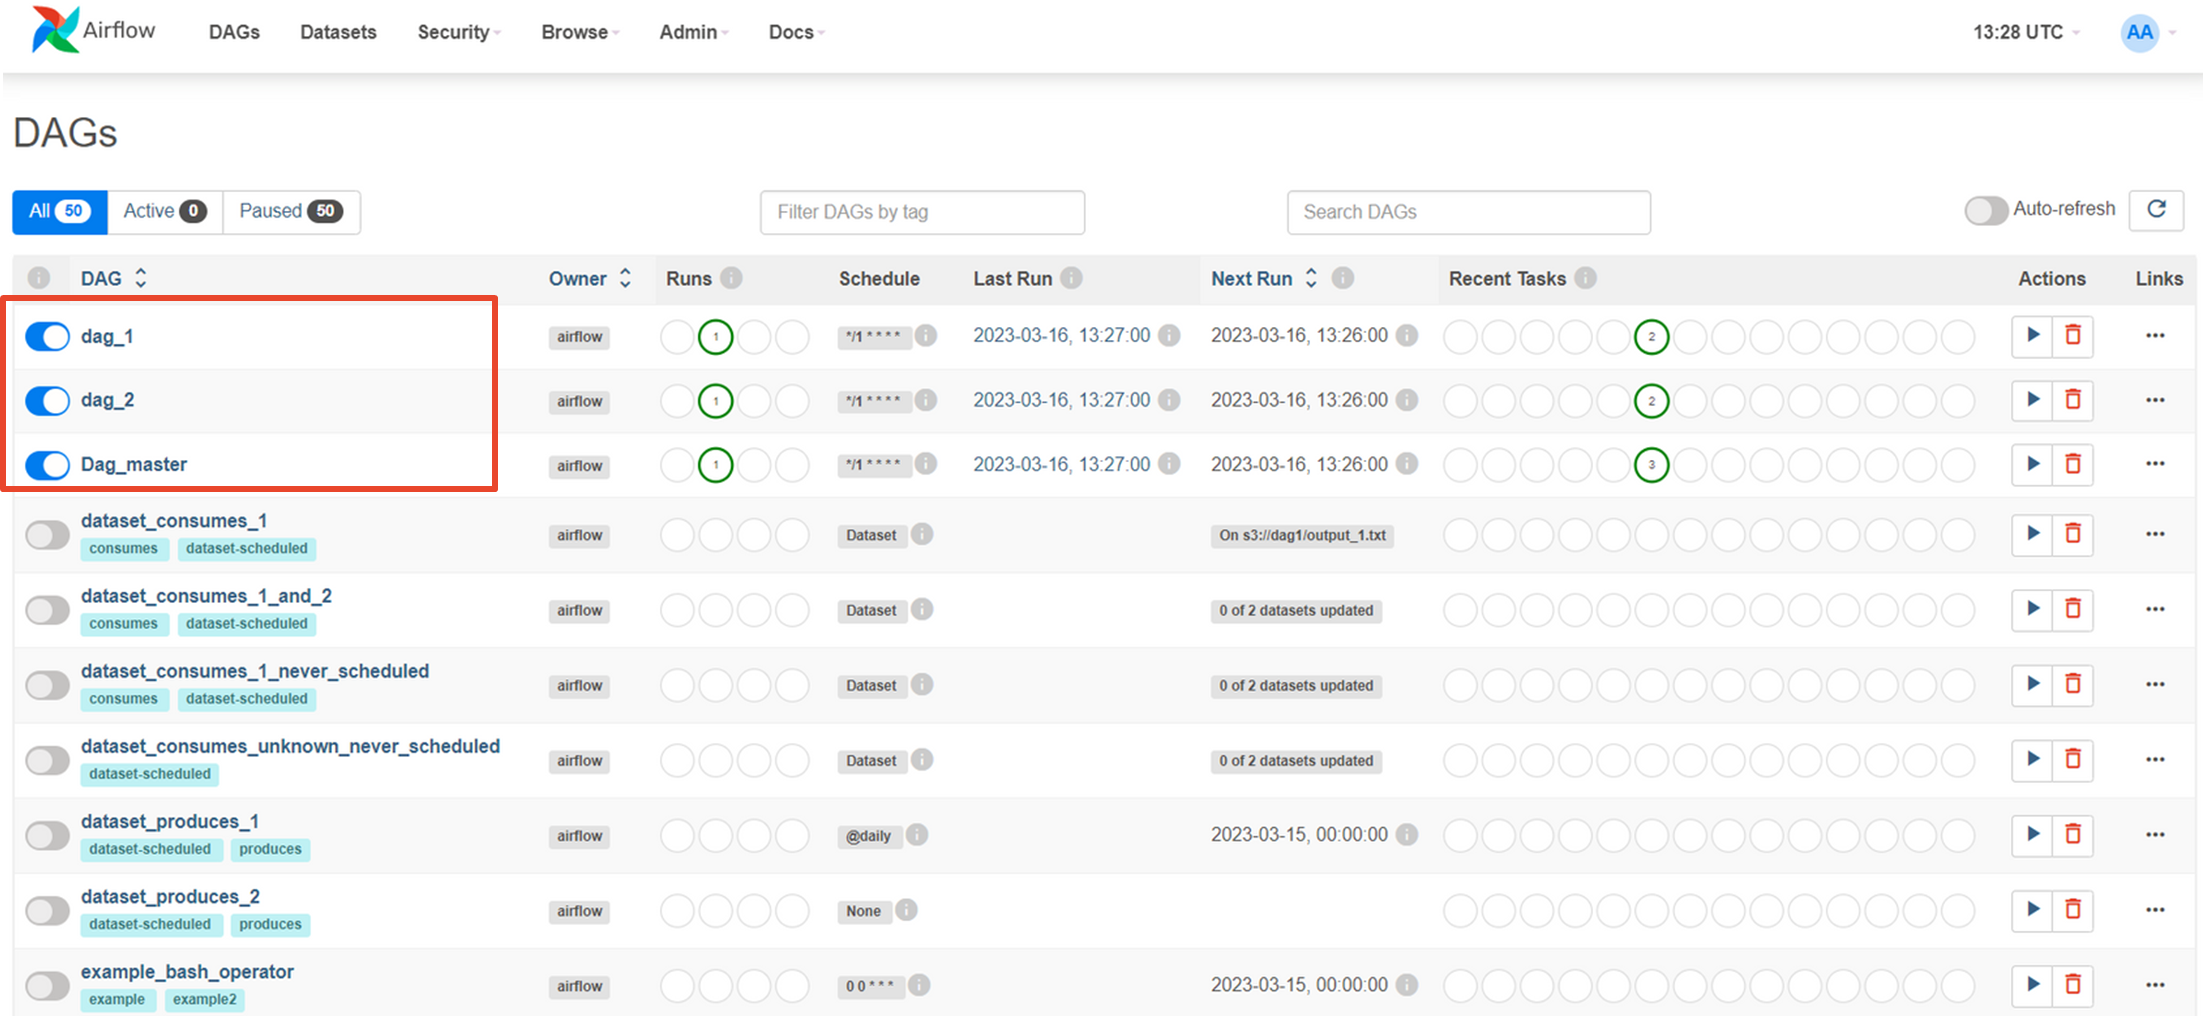

### ACTIVATION DES DAGS-DAG1

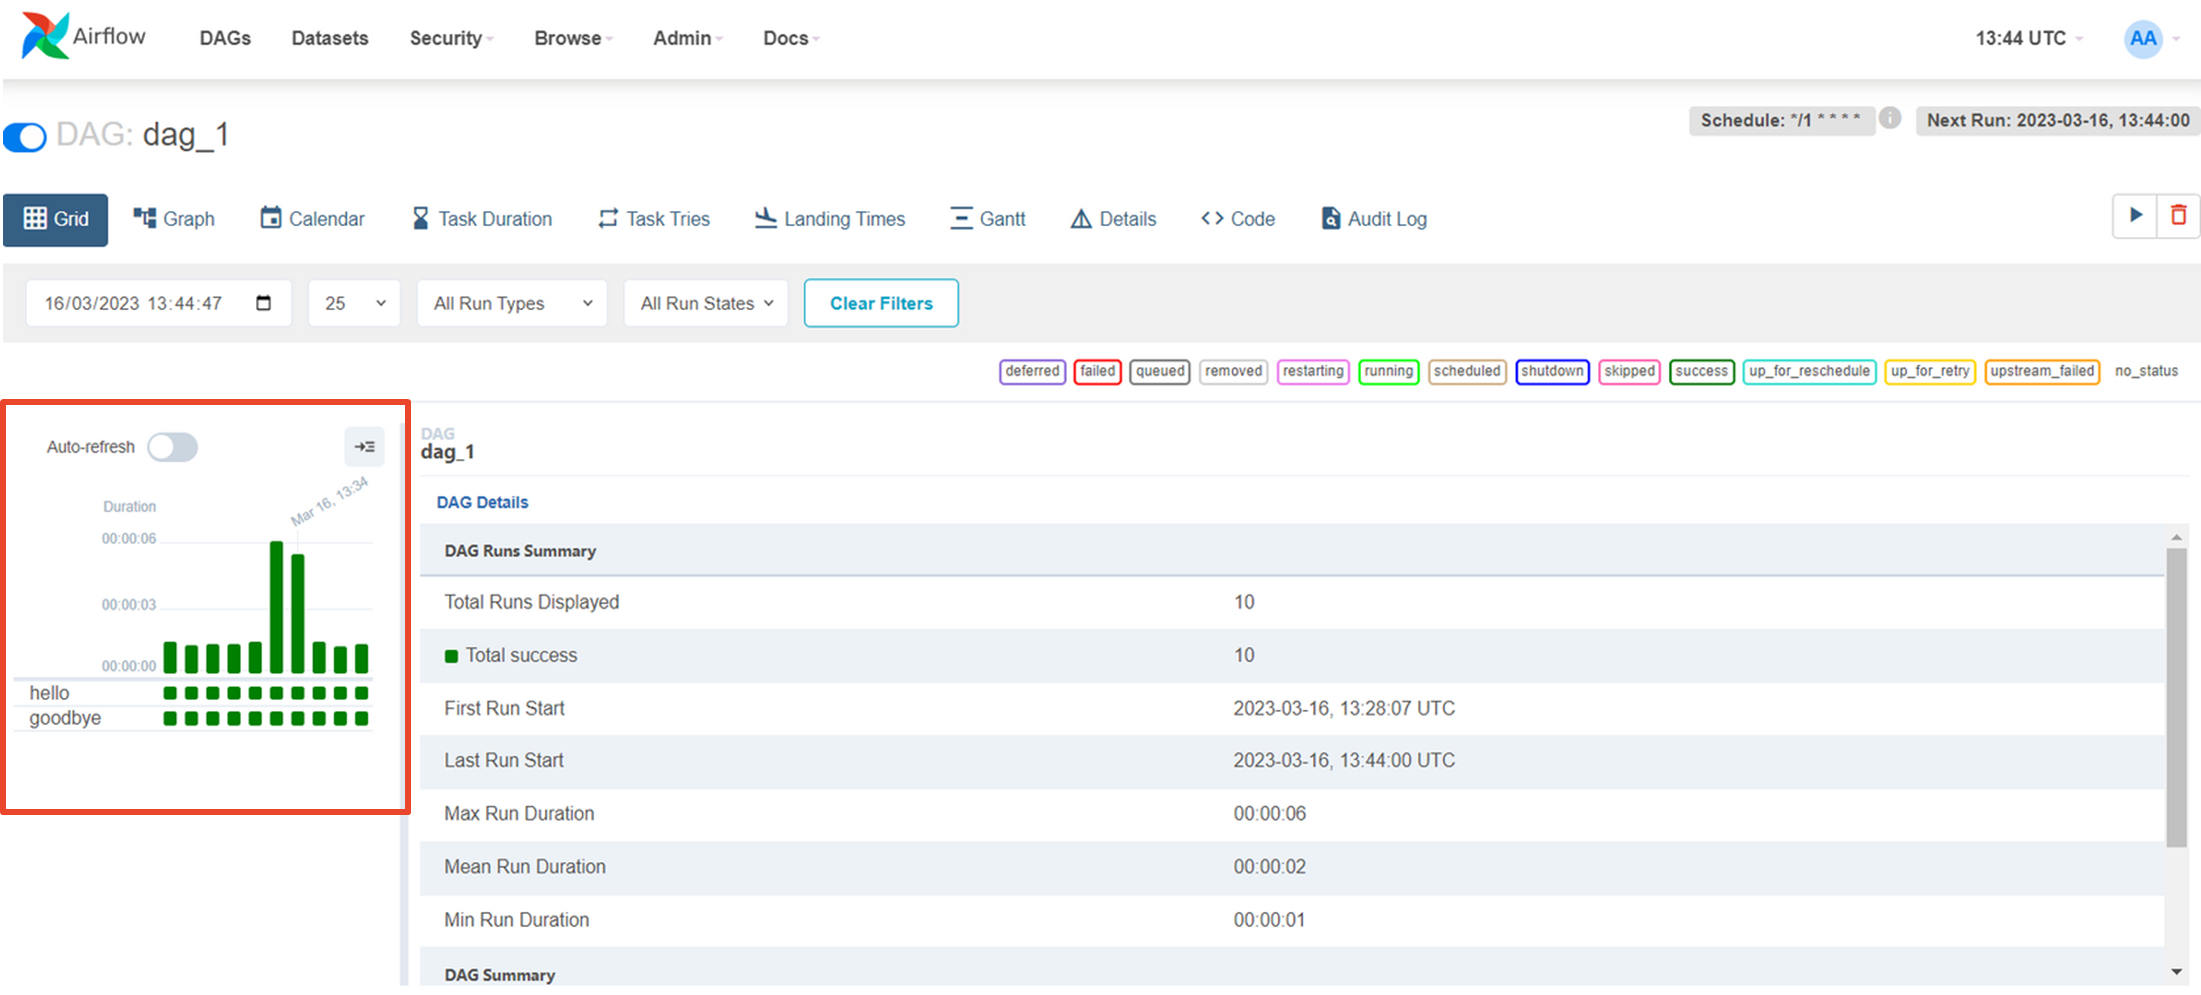

### ACTIVATION DES DAGS-DAG2

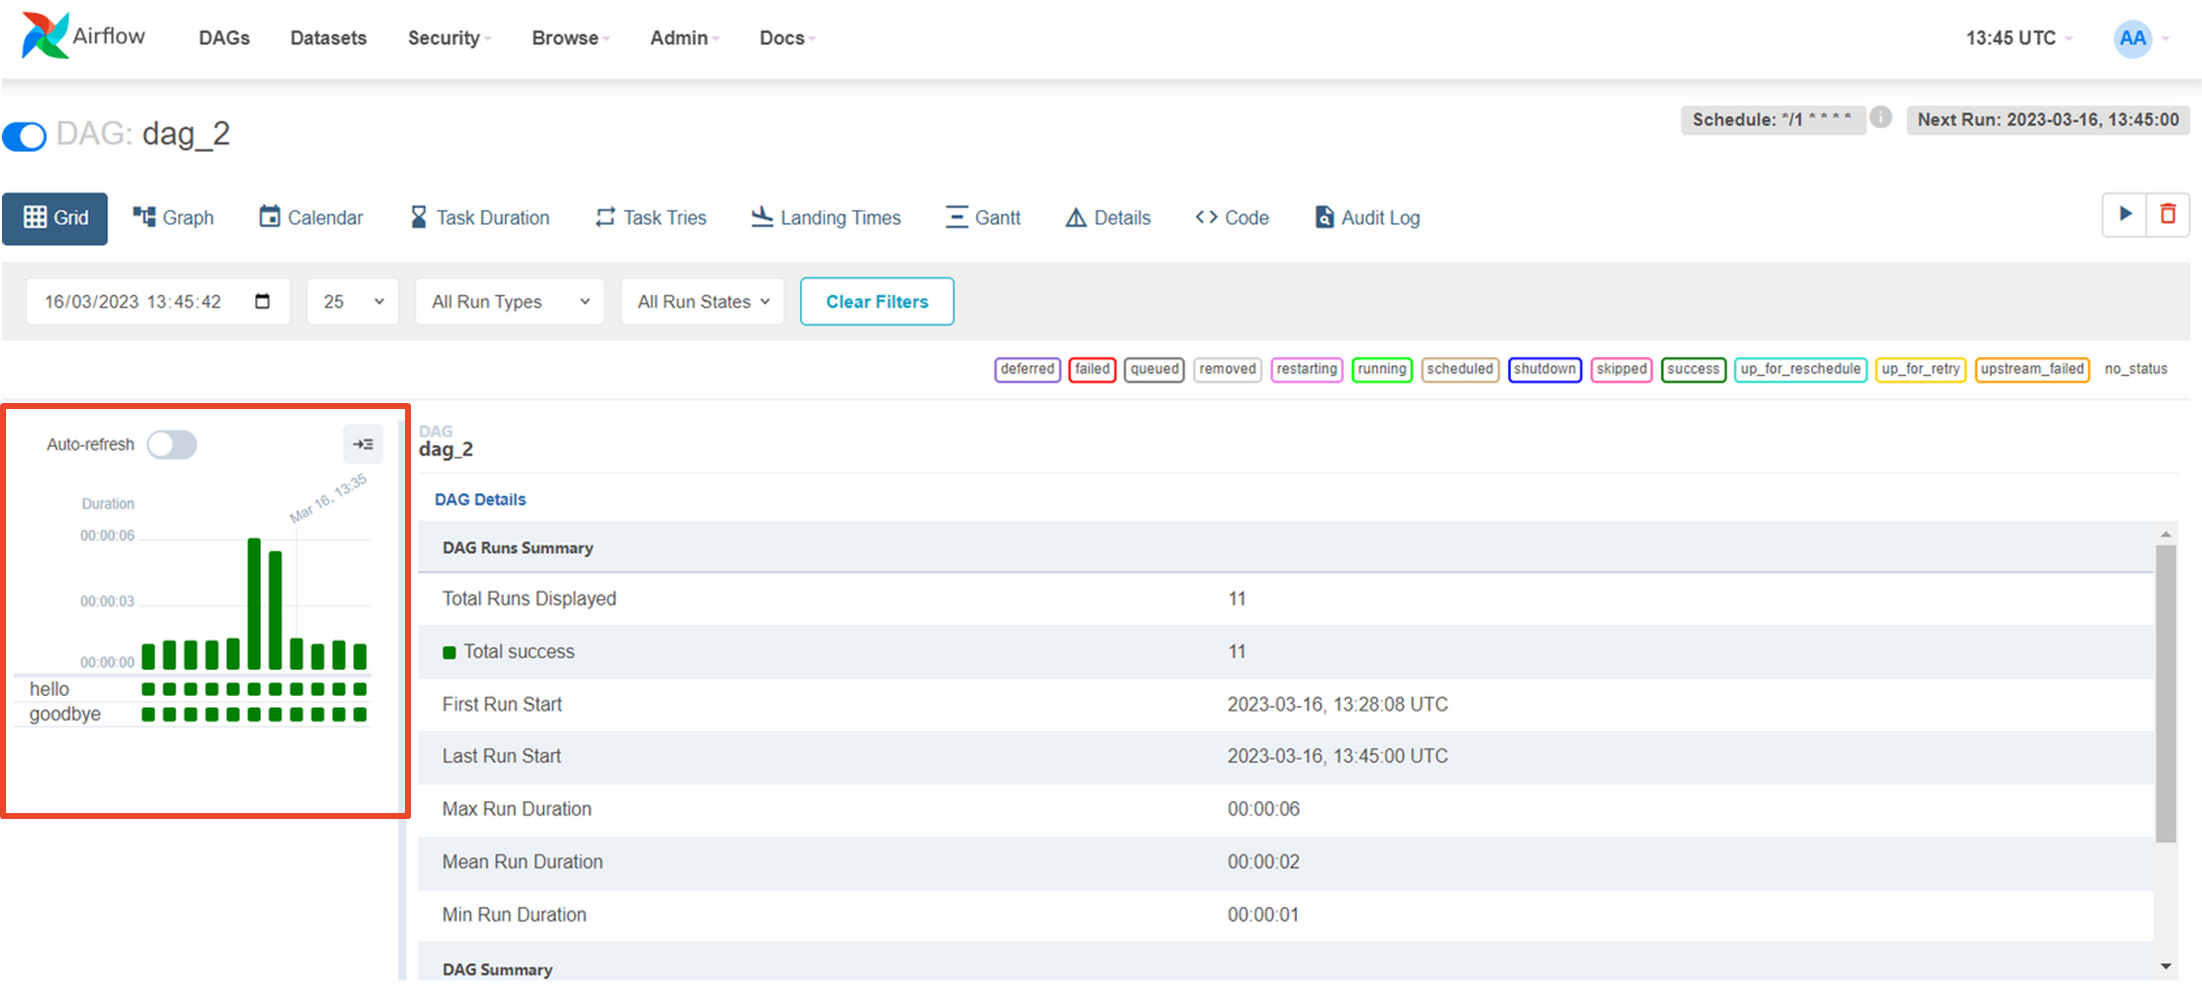

### ACTIVATION DES DAGS-DAG_MASTER


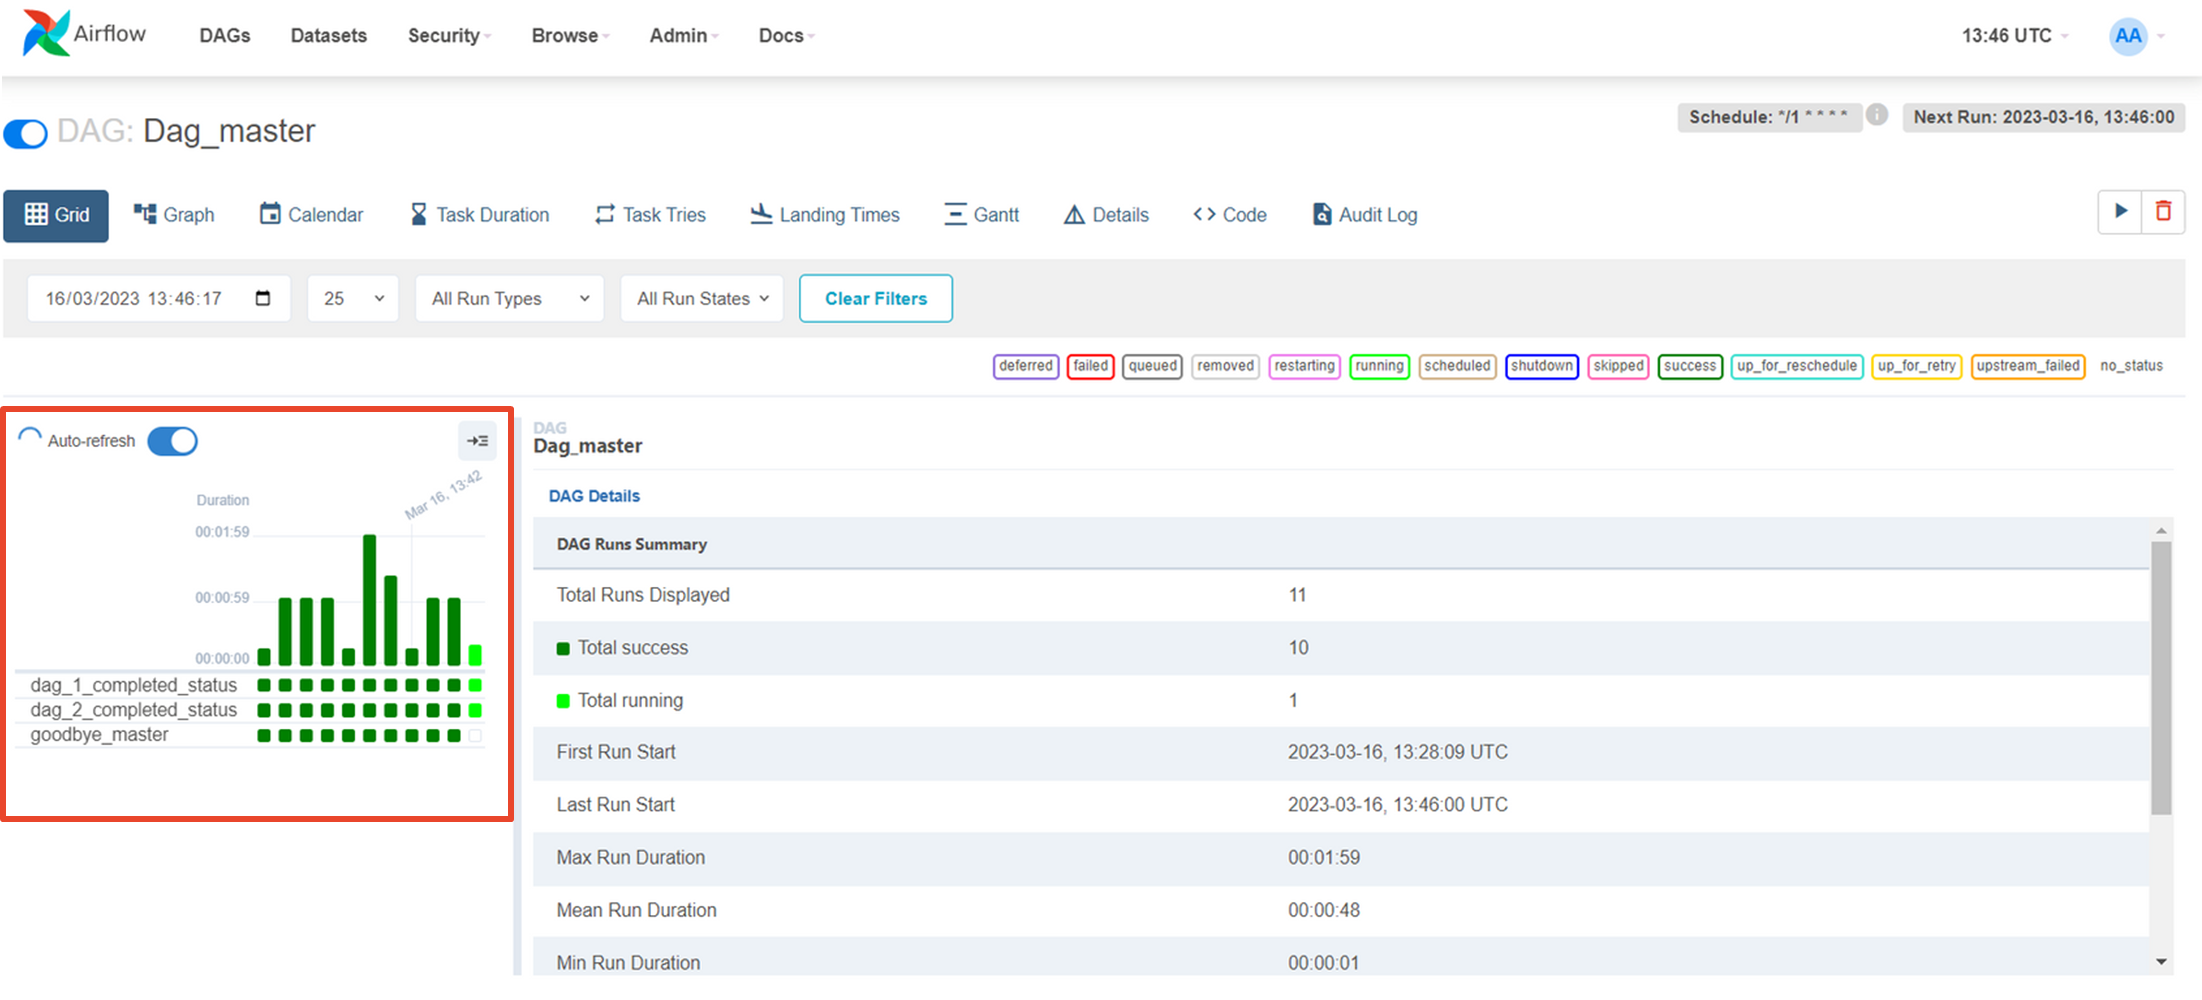